In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import keras
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense, Activation, SpatialDropout3D
from keras.layers import Dropout, Input, BatchNormalization, Lambda
from keras.losses import mae, mse, binary_crossentropy
from keras.optimizers import Adam, Adadelta, Adagrad, SGD
from keras.models import Model

Using TensorFlow backend.


In [3]:
## extra imports to set GPU options
import tensorflow as tf
from keras import backend as k
 
###################################
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
#config.gpu_options.allow_growth = True
 
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))
###################################

np.random.seed(1)
tf.set_random_seed(2)

In [4]:
def Conv3D_model(input_shape):
    input_layer = Input(input_shape)
    prev_layer = input_layer
    for i in range(4):
        layer = Conv3D(filters=(i+1)*8, kernel_size=(3, 3, 3))(prev_layer)
        layer = SpatialDropout3D(0.1)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPool3D(pool_size=(2, 2, 2))(layer)
        layer = BatchNormalization()(layer)
        prev_layer = layer
    
    flatten_layer = Flatten()(prev_layer)
    age_layer = Dense(units=1, activation='linear' , name='age')(flatten_layer)
    sex_layer = Dense(units=1, activation='sigmoid', name='sex')(flatten_layer)
    
    return Model(inputs=input_layer, outputs=[age_layer, sex_layer])

In [5]:
# Handle missing labels, mask for empty value
mask_value = -1
def masked_mae(y_true, y_pred):
    mask = k.cast(k.not_equal(y_true, mask_value), k.floatx())
    return mae(y_true * mask, y_pred * mask)

def masked_mse(y_true, y_pred):
    mask = k.cast(k.not_equal(y_true, mask_value), k.floatx())
    return mse(y_true * mask, y_pred * mask)

def masked_binary_crossentropy(y_true, y_pred):
    mask = k.cast(k.not_equal(y_true, mask_value), k.floatx())
    return binary_crossentropy(y_true * mask, y_pred * mask)

def masked_accuracy(y_true, y_pred):
    mask = k.cast(k.not_equal(y_true, mask_value), k.floatx())
    return keras.metrics.binary_accuracy(y_true * mask, y_pred * mask)

In [6]:
class DataGen:
    
    def __init__(self, csv,  directory):
        df = pd.read_csv(os.path.join(directory, csv))
        self.dir = directory
        self.filename = np.array(df['file'])
        
        # missing values should be -1
        self.age      = np.array(df['age'])
        
        self.sex = -np.ones(len(df))
        self.sex[df['sex'] == 'm'] = 0
        self.sex[df['sex'] == 'f'] = 1
        
        one_brain = np.array(nib.load( os.path.join(self.dir, self.filename[0]) ).get_data())
        self.shape = one_brain.shape
        self.dtype = one_brain.dtype
        self.total_samples = len(self.filename)
        
        self.next_index = 0
        self.init()
        
        
    def init(self):
        rand_indicies = np.random.permutation(np.arange(len(self.filename)))
        self.filename = self.filename[rand_indicies]
        self.age = self.age[rand_indicies]
        self.sex = self.sex[rand_indicies]
        self.next_index = 0
        
    def samples_left(self):
        return self.total_samples - self.next_index
        
    def getBatch(self, n_samples):
        n_samples_left = self.samples_left()
        assert n_samples_left>0, "No samples left, call dataGen.init()"
        
        n_samples = n_samples if n_samples_left>n_samples else n_samples_left
        data = np.empty((n_samples,)+self.shape+(1,), self.dtype)
        age_label = np.empty(n_samples, self.dtype)
        sex_label = np.empty(n_samples, self.dtype)
        # should spawn a thread to load data
        for i in range(n_samples):
            data[i,:,:,:,0] = sampNorm(nib.load(os.path.join(self.dir, self.filename[self.next_index])).get_data())
            age_label[i] = self.age[self.next_index]
            sex_label[i] = self.sex[self.next_index]
            self.next_index = self.next_index+1
        
        return data, [age_label, sex_label]
    
    # generator for keras fit_generator function
    def generator(self, batch_size, num_batches_to_load):
        # using a batch_size such that i*batch_size = dataset_size
        #assert self.total_samples%batch_size == 0, "Batch_size should be a divisor of DataGen.total_sample"
        num_batches = self.total_samples//batch_size
        #assert num_batches%num_batches_to_load==0, "num_batches_to_load should be a divisor of num_batches"
        num_loads = num_batches//num_batches_to_load
        while True:
            self.init()
            for load in range(num_loads):
                X, y = self.getBatch(num_batches_to_load*batch_size)
                age,sex = y
                for index in range(num_batches_to_load):
                    yield (X[index*batch_size:(index+1)*batch_size], [age[index*batch_size:(index+1)*batch_size], sex[index*batch_size:(index+1)*batch_size]])


In [7]:
def sampNorm(X):

    mean = np.mean(X) 
    std = np.std(X)
  
    return (X - mean) / (std + np.finfo(float).eps)

In [8]:
def kerasPlot(history):
    plt.subplot(3, 1, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['Training', 'Validation'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    
    plt.subplot(3, 2, 3)
    plt.title('Age')
    plt.plot(history.history['age_loss'])
    plt.plot(history.history['val_age_loss'])
    plt.legend(['Training', 'Validation'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    
    plt.subplot(3, 2, 4)
    plt.title('Sex')
    plt.plot(history.history['sex_loss'])
    plt.plot(history.history['val_sex_loss'])
    plt.legend(['Training', 'Validation'])
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    
    plt.subplot(3, 2, 5)
    plt.plot(history.history['age_masked_mae'])
    plt.plot(history.history['val_age_masked_mae'])
    plt.legend(['Training', 'Validation'])
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    
    plt.subplot(3, 2, 6)
    plt.plot(history.history['sex_masked_accuracy'])
    plt.plot(history.history['val_sex_masked_accuracy'])
    plt.legend(['Training', 'Validation'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    
    plt.show()

In [9]:
dg = DataGen('train.csv', './data')
dg_val = DataGen('validation.csv', './data')
print("Training Samples:", dg.total_samples, ",  Validation Samples:", dg_val.total_samples,)

Training Samples: 2994 ,  Validation Samples: 200


In [10]:
model = Conv3D_model(dg.shape+(1,)) # +(1,),single channel
batch_size = 5
load_size = 30 # how many batches should be in ram
epochs = 50

model.compile(optimizer='Adam',
              loss={'age':masked_mae, 'sex':masked_binary_crossentropy},
              loss_weights={'age': 1, 'sex': 10},
              metrics={'age':masked_mae, 'sex':masked_accuracy})

In [11]:
history = model.fit_generator(dg.generator(batch_size, load_size),
                              steps_per_epoch = np.ceil(dg.total_samples/batch_size),
                              epochs = epochs,
                              validation_data=dg_val.generator(batch_size, load_size),
                              validation_steps = np.ceil(dg_val.total_samples/batch_size),
                              verbose=1)

Epoch 1/50
599/599 [==============================] - 671s 1s/step - loss: 26.9772 - age_loss: 9.8701 - sex_loss: 1.7107 - age_masked_mae: 9.8701 - sex_masked_accuracy: 0.6114 - val_loss: 12.3261 - val_age_loss: 7.8257 - val_sex_loss: 0.4500 - val_age_masked_mae: 7.8257 - val_sex_masked_accuracy: 0.8200
Epoch 2/50
599/599 [==============================] - 631s 1s/step - loss: 20.2513 - age_loss: 8.5360 - sex_loss: 1.1715 - age_masked_mae: 8.5360 - sex_masked_accuracy: 0.6888 - val_loss: 11.3783 - val_age_loss: 7.2494 - val_sex_loss: 0.4129 - val_age_masked_mae: 7.2494 - val_sex_masked_accuracy: 0.8300
Epoch 3/50
599/599 [==============================] - 605s 1s/step - loss: 15.8769 - age_loss: 7.6593 - sex_loss: 0.8218 - age_masked_mae: 7.6593 - sex_masked_accuracy: 0.7482 - val_loss: 11.3601 - val_age_loss: 6.2995 - val_sex_loss: 0.5061 - val_age_masked_mae: 6.2995 - val_sex_masked_accuracy: 0.8100
Epoch 4/50
599/599 [==============================] - 639s 1s/step - loss: 12.3001 - 

Epoch 28/50
599/599 [==============================] - 637s 1s/step - loss: 3.4090 - age_loss: 3.0100 - sex_loss: 0.0399 - age_masked_mae: 3.0100 - sex_masked_accuracy: 0.9876 - val_loss: 6.5265 - val_age_loss: 3.4455 - val_sex_loss: 0.3081 - val_age_masked_mae: 3.4455 - val_sex_masked_accuracy: 0.9000
Epoch 29/50
599/599 [==============================] - 631s 1s/step - loss: 3.3283 - age_loss: 3.1182 - sex_loss: 0.0210 - age_masked_mae: 3.1182 - sex_masked_accuracy: 0.9920 - val_loss: 6.2399 - val_age_loss: 4.0200 - val_sex_loss: 0.2220 - val_age_masked_mae: 4.0200 - val_sex_masked_accuracy: 0.9200
Epoch 30/50
599/599 [==============================] - 598s 999ms/step - loss: 3.3033 - age_loss: 2.9230 - sex_loss: 0.0380 - age_masked_mae: 2.9230 - sex_masked_accuracy: 0.9846 - val_loss: 6.3597 - val_age_loss: 3.8853 - val_sex_loss: 0.2474 - val_age_masked_mae: 3.8853 - val_sex_masked_accuracy: 0.9200
Epoch 31/50
599/599 [==============================] - 638s 1s/step - loss: 3.2319 - 

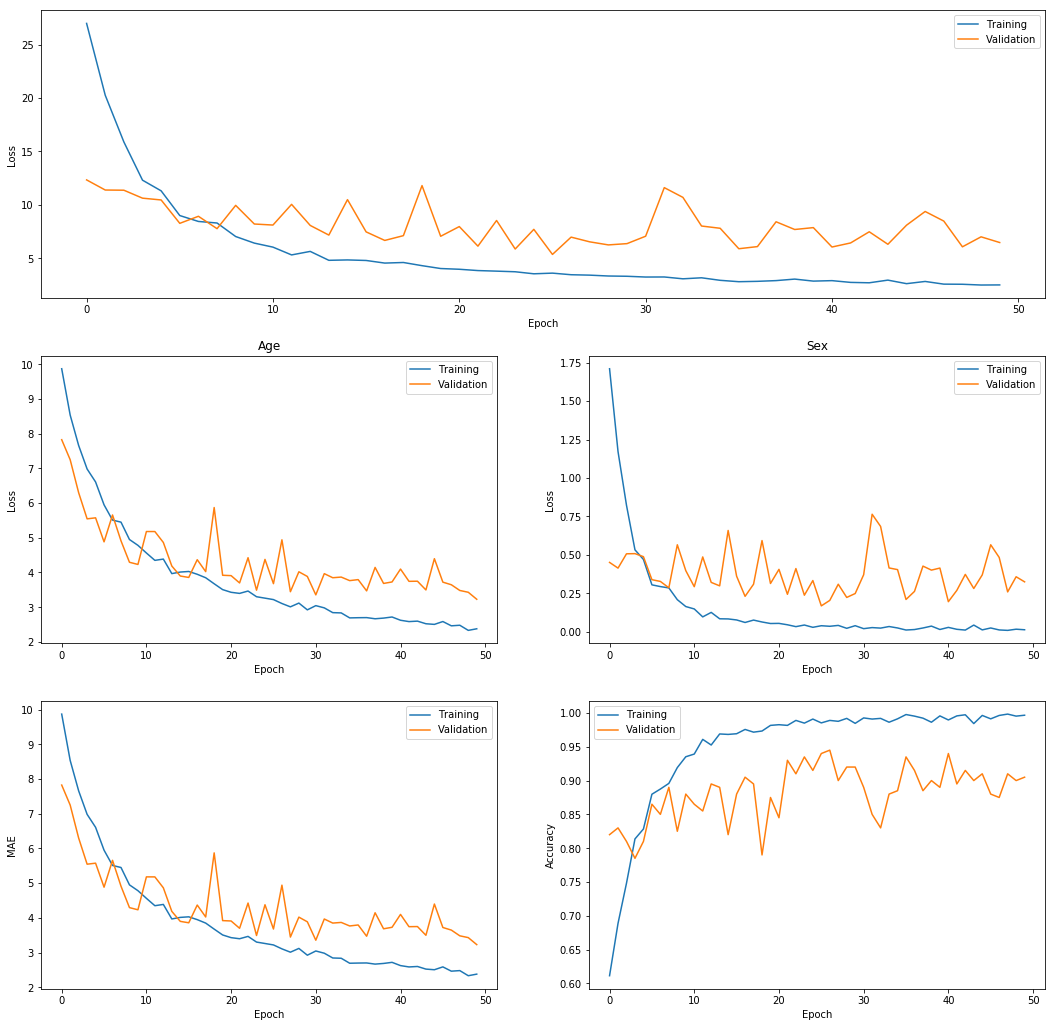

In [12]:
plt.rcParams['figure.figsize'] = [18, 18]
kerasPlot(history)

In [13]:
from sklearn.metrics import accuracy_score, mean_absolute_error
IXI_val = DataGen('IXI_val.csv', './data')
OASIS_val = DataGen('OASIS3_val.csv', './data')
openfmri_val = DataGen('openfmri_val.csv', './data')

IXI_val_data = IXI_val.getBatch(IXI_val.total_samples)
OASIS_val_data = OASIS_val.getBatch(OASIS_val.total_samples)
openfmri_val_data = openfmri_val.getBatch(openfmri_val.total_samples)

In [14]:
X,y = IXI_val_data
age, sex = y
age_hat, sex_hat = model.predict(X, batch_size=5)
print("IXI age mean absolute error:",mean_absolute_error(age[ age!= -1], age_hat[ age!= -1] ))
print("IXI sex validation accuracy:",accuracy_score(sex[ sex!=-1 ],sex_hat[ sex!=-1 ]>.5 ))

IXI age mean absolute error: 5.739635
IXI sex validation accuracy: 0.88


In [15]:
X,y = OASIS_val_data
age, sex = y
age_hat, sex_hat = model.predict(X, batch_size=5)
print("OASIS age not available" if np.all(age==-1) else "ERROR")
print("OASIS sex validation accuracy:",accuracy_score(sex[ sex!=-1],sex_hat[ sex!=-1]>.5))

OASIS age not available
OASIS sex validation accuracy: 0.96


In [16]:
X,y = openfmri_val_data
age, sex = y
age_hat, sex_hat = model.predict(X, batch_size=5)
print("openfmri age mean absolute error:",mean_absolute_error(age[ age!= -1], age_hat[ age!= -1] ))
print("openfmri sex validation accuracy:",accuracy_score(sex[ sex!=-1],sex_hat[ sex!=-1]>.5))

openfmri age mean absolute error: 3.9890037
openfmri sex validation accuracy: 0.8865979381443299
